# Data Analysis and AI 

---

## Introduction: The Screening Bottleneck

You run a contract toxicology laboratory. A pharmaceutical company has approached you with a screening project: they need to test 170 chemical compounds against 26 bacterial strains that were isolated from contaminated environments. The goal is to identify which combinations show growth inhibition - in other words, which chemicals are toxic to which strains. This might sound straightforward, but the scale is daunting. Each strain-chemical pair requires 4 biological replicates to account for experimental variation, which means you're looking at 17,680 individual growth curves to measure and analyze.

The standard protocol for this kind of work is well-established but time-consuming. You measure optical density (a proxy for cell density) every hour for 72 hours, then compare the final OD to control cultures grown in just the vehicle (DMSO). This gives you a definitive answer about whether a chemical inhibited growth. But here's the problem: even with multiple plate readers running continuously, the total instrument time required is substantial. The project timeline is tight, and you need to find ways to accelerate the screening process without sacrificing accuracy. If you could measure for just 24 hours instead of 72 hours per experiment, you'd achieve a 3x speedup in throughput, making the project much more feasible within budget and timeline constraints.

This brings us to the central question of this lecture: Can we predict the 72-hour outcome from early measurements? If the answer is yes, we can dramatically reduce screening time and make the project profitable. This is a classic machine learning problem: using limited early-time data to predict a long-term outcome.

Today we'll compare four fundamentally different approaches to this problem: feeding raw data to neural networks, dimensionality reduction through PCA, feature engineering based on biological knowledge, and automatic feature learning with CNNs. Each represents a different philosophy about extracting information from time-series data.

---

## Configuration

Before we dive into the analysis, we need to establish our experimental parameters. The most critical parameter is our prediction window: how many hours of data will we use to make our prediction? Throughout this notebook, we'll work primarily with 24-hour data, though you should feel free to experiment with earlier timepoints like 6, 12, or 18 hours.

We're comparing all treatments against DMSO (dimethyl sulfoxide), which is the standard vehicle for dissolving hydrophobic compounds in aqueous media.

In [1]:
# %pip install imblearn pandas matplotlib scipy numpy scikit-learn torch tqdm

In [2]:
# Core parameters
MAX_HOURS = 24          # Prediction timepoint (try 6, 12, 18, 24 for Exercise 3)
CONTROL_CHEMICAL = 'DMSO'
INHIBITION_THRESHOLD = 0.5
RANDOM_SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2


---

## Data Loading and Exploration

We'll work with real data from an [environmental toxicology study](https://doi.org/10.1093/femsec/fiaf047). The bacterial strains in this dataset weren't your typical laboratory workhorses like *E. coli* K-12 or *B. subtilis* 168. Instead, these strains were isolated from contaminated environmental sites - places where bacteria have been exposed to pollutants for generations and may have evolved resistance mechanisms. This makes them particularly interesting for toxicology studies, as their responses better reflect what happens in real-world contaminated environments.

The dataset includes 24 bacterial species spanning remarkably diverse phylogenetic groups: *Neobacillus*, *Bacillus*, *Arthrobacter*, *Flavobacterium*, *Pseudomonas* (multiple species), *Rhizobium*, *Agrobacterium*, *Sphingomonas*, *Prolinoborus*, *Paenibacillus*, *Serratia*, *Aeromonas* (multiple species), *Microbacterium*, *Hymenobacter*, *Carnobacterium*, and *Oryzobacter*. This phylogenetic diversity is important: different bacterial lineages have fundamentally different cell wall structures, metabolic capabilities, and stress response systems.

The dataset structure follows a standard format for high-throughput screening experiments. Each row represents a single timepoint measurement from one well of a 96-well microtiter plate. The key columns are `Time` (hours since inoculation), `OD600`, `Species` (the taxonomic identification of the strain), `Strain` (a specific isolate identifier), `Compound` (the chemical being tested), and `Rep` (biological replicate number). This organization allows us to reconstruct complete growth curves for every strain-chemical-replicate combination.

The 170 compounds tested are primarily agricultural chemicals - pesticides (like malathion, chlorpyrifos), fungicides (like propiconazole, tebuconazole), and herbicides (like glyphosate, atrazine). The choice of environmentally-isolated bacteria and agricultural chemicals reflects real-world ecotoxicology concerns: understanding how these widely-used agrochemicals affect soil and water microbiomes.


In [3]:
import os
import urllib.request

data_file = 'isolate-growth-curves.csv'
if not os.path.exists(data_file):
    print("Downloading dataset from Figshare...")
    url = "https://figshare.com/ndownloader/files/53285996"
    urllib.request.urlretrieve(url, data_file)
    print(f"Downloaded {data_file}")
else:
    print(f"Found {data_file}")

Found isolate-growth-curves.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from scipy.interpolate import interp1d
from scipy.special import expit
from tqdm import tqdm

# Load data
data = pd.read_csv('isolate-growth-curves.csv')

# Column mapping
time_col, od_col, species_col = 'Time', 'OD600', 'Species'
strain_col, chem_col, rep_col = 'Strain', 'Compound', 'Rep'

print(f"Dataset: {data.shape[0]} rows, {data.shape[1]} columns")
print(f"\nExperimental design:")
print(f"  {data[strain_col].nunique()} bacterial strains")
print(f"  {data[chem_col].nunique()} chemicals tested")
print(f"  {data[rep_col].nunique()} replicates per condition")

# Show structure
with pd.option_context('display.max_columns', None):
    display(data.head())

/var/folders/nr/_hn8w4_n1_39r9hhv2c600040000gp/T/ipykernel_6969/2060303228.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('isolate-growth-curves.csv')


Dataset: 1054871 rows, 30 columns

Experimental design:
  26 bacterial strains
  170 chemicals tested
  3 replicates per condition


,Time,Well,OD600,Plate,Library,Rep,LibRep,Row,Column,Compound,Supplier.order.no.,EMBL.CBCF.Id,Supplier,Strain,Product..common.name.,Chemical.Family,Target,Specific.Target,Chem.ID,Species,Phylum,Class,Order,Family,Genus,Strain.id,ID,Location,Environment,LibRepStrainWell
0,0.001667,A1,0.042,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
1,1.001111,A1,0.043,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
2,2.001667,A1,0.044,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
3,3.001944,A1,0.045,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
4,4.002222,A1,0.047,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1


In [5]:
vals = data[species_col].unique()
print(f"\nSpecies ({len(vals)}): {vals}")

vals = data[strain_col].unique()
print(f"\nStrains ({len(vals)}): {vals}")

vals = data[[species_col, strain_col]].drop_duplicates().sort_values([species_col])
print(f"\nSpecies+Strain ({len(vals)}): \n{vals}")


Species (24): ['Neobacillus soli' 'Bacillus foraminis' 'Arthrobacter humicola'
 'Arthrobacter sp.' 'Flavobacterium glaciei' 'Flavobacterium succinicans'
 'Pseudomonas baetica' 'Pseudomonas sp.' 'Rhizobium herbae'
 'Agrobacterium sp.' 'Sphingomonas sp.' 'Prolinoborus fasciculus'
 'Paenibacillus castaneae' 'Pseudomonas vancouverensis'
 'Pseudomonas mandelii' 'Serratia sp. 2015-2462-01' 'Aeromonas sp. AE235'
 'Aeromonas sobria' 'Pseudomonas peli' 'Microbacterium arborescens'
 'Hymenobacter glaciei' 'Carnobacterium gallinarum' 'Aeromonas popoffii'
 'Oryzobacter terrae']

Strains (26): ['IL 74' 'R2A_RUF3_11' 'IL 306' 'R2A_SUG4_13' 'IL 302' 'R2A_MUC9_2'
 'IL 331' 'PSA_SUH4_5' 'IL 371' 'PSA_SUA5_8' 'R2A_SUH4_15' 'IL 88'
 'IL 100' 'IL 186' 'IL 322' 'IL 333' 'IL 350' 'IL 353' 'IL 374' 'IL 380'
 'IL 390' 'IL 442' 'IL 448' 'IL 487' 'IL 527' 'IL 565']

Species+Strain (26): 
                            Species       Strain
933335           Aeromonas popoffii       IL 487
723095             Aeromon

In [6]:
vals = data[chem_col].unique()
print(f"\nCompounds ({len(vals)}): {vals}")


Compounds (170): ['THIABENDAZOLE' 'PROPICONAZOLE' 'NOVALURON' 'DMSO' 'BIFENTHRIN' 'CAPTAN'
 'PIRIMIPHOS-METHYL' 'FLUROXYPYR' 'INDOXACARB' 'TRIFLOXYSTROBIN'
 'ACETOCHLOR'
 'ACETAMIPRID; N-(6-CHLORO-3-PYRIDYLMETHYL)-N-CYANO-N-METHYLACETAMIDINE'
 'DIURON' 'CYPRODINIL' 'FENOXAPROP RACEMATE' 'ISOXAFLUTOLE'
 'TRIADIMENOL A' 'HEXACHLOROPHENE' 'PIPERONYL BUTOXIDE' 'MALATHION'
 'SPIROTETRAMAT' 'CLETHODIM (MIXTURE OF ISOMERS)' 'empty' 'S-METOLACHLOR'
 'PYRIDABEN' 'BUPIRIMATE' 'CHLORANTRANILIPROL' 'METRAFENONE' 'CARBOSULFAN'
 'PYRIPROXIFEN' 'DIFENOCONAZOL' 'FENAZAFLOR' 'DIFLUFENICAN' 'TRICYCLAZOLE'
 'ACLONIFEN' 'BAYTHROID (MIXTURE OF ISOMERS)' 'TOLFENPYRAD' 'FLORASULAM'
 'PYMETROZIN' 'PROCHLORAZ' 'PYRACLOSTROBIN' '4,4-DDT' 'CARBENDAZIM'
 'DIMETHENAMID' 'FLUBENDIAMID' 'BIFENAZATE' 'PENDIMETHALIN' 'PHOSMET'
 'PICOXYSTROBIN' 'DICAMBA' 'CHLORPYRIPHOS' 'DELTAMETHRIN' 'FOLPET'
 'PERMETHRIN (MIXTURE OF CIS AND TRANS ISOMERE)' 'ETONFENPROX' 'LINDAN'
 'CLOTHIANIDIN' 'BIXAFEN' 'BUPROFEZIN' 'METALAXYL' 'FL

In [7]:
vals = data[strain_col].value_counts()
print(f"\nRows per strain ({len(vals)}): \n{vals}")

print(f"Theoretical max number of rows per strain: {170 * 4 * 73}")


Rows per strain (26): 
Strain
IL 186         42048
IL 100         42048
IL 487         42048
IL 448         42048
IL 442         42048
IL 390         42048
IL 380         42048
IL 374         42048
IL 350         42048
IL 333         42048
IL 322         42048
IL 565         42048
IL 88          42048
IL 74          41376
IL 306         41303
PSA_SUA5_8     41184
IL 371         41184
PSA_SUH4_5     41184
IL 331         41184
R2A_MUC9_2     41184
IL 302         41184
R2A_SUG4_13    41184
IL 353         37440
IL 527         37440
R2A_RUF3_11    35040
R2A_SUH4_15    27360
Name: count, dtype: int64
Theoretical max number of rows per strain: 49640


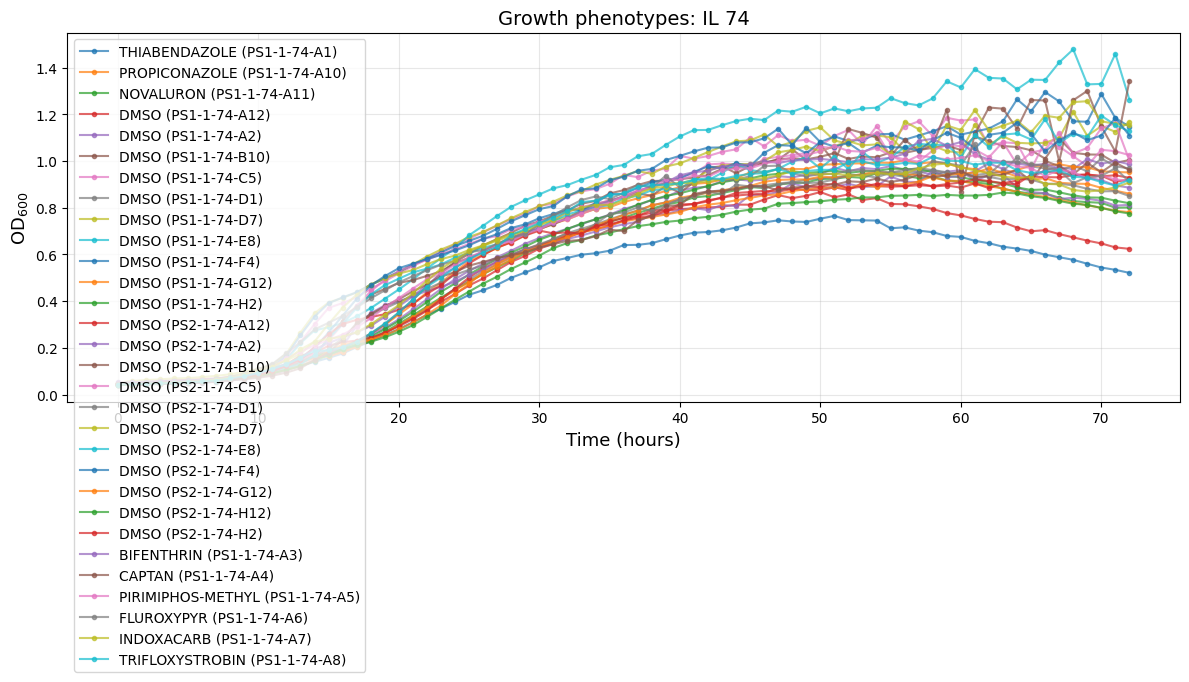

In [8]:
def plot_growth_curves(data, strain, chemicals, replicate=1):
    """
    Plot growth curves for one strain across multiple chemicals.
    This reveals the qualitative differences we need to classify.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for chem in chemicals:
        subset = data[
            (data[strain_col] == strain) &
            (data[chem_col] == chem) &
            (data[rep_col] == replicate)
        ]
        
        if len(subset) > 0:
            # Group by unique well identifier
            for well in subset['LibRepStrainWell'].unique():
                well_data = subset[subset['LibRepStrainWell'] == well].sort_values(by=time_col)
                time = well_data[time_col].values
                od = well_data[od_col].values
                ax.plot(time, od, "o-", label=f"{chem} ({well})", alpha=0.7, markersize=3)
    
    ax.set_xlabel("Time (hours)", fontsize=13)
    ax.set_ylabel("OD$_{600}$", fontsize=13)
    ax.set_title(f"Growth phenotypes: {strain}", fontsize=14)
    ax.legend(fontsize=10, loc="upper left")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Select one strain and several chemicals to visualize
example_strain = data[strain_col].unique()[0]
example_chems = data[chem_col].unique()[:10]
plot_growth_curves(data, example_strain, example_chems)


---

## Creating Labels: The Control Comparison Problem

How do we define "inhibited" versus "not inhibited"? You might think we could just compare final optical densities at 72 hours, but this approach has a subtle problem. Different bacterial strains have dramatically different baseline growth characteristics. Some species naturally reach OD values of 3.0 or higher at stationary phase, while others plateau at OD 0.8 even under optimal conditions. This variation reflects differences in cell size, cell morphology, and the scattering properties of different bacterial envelopes. A *Bacillus* spore-former growing to OD 1.2 might represent completely normal growth, while a *Pseudomonas* strain at the same density could be severely inhibited.

This is why we need strain-specific comparisons. The most used metric is Area Under the Curve (AUC):

$$\text{AUC} = \int_0^{72h} \text{OD}(t) \, dt$$

The AUC captures the entire growth trajectory: how long the cells spent in lag phase before initiating growth, how fast they grew exponentially, what final density they reached, and how long they maintained that density at stationary phase. It's a comprehensive measure of total biomass production over the entire experiment. Unlike using just the final OD, which gives you a single snapshot, the AUC integrates over all dynamics. A culture that reaches the same final OD but gets there 12 hours earlier will have a higher AUC because it spent more time at high density.

The labeling algorithm works as follows. For each bacterial strain *s*, we first compute the average AUC in the control condition (DMSO vehicle only): $\text{AUC}_{\text{control}}^{(s)}$. This represents the baseline biomass production capacity of that strain under optimal conditions. For each chemical treatment *c*, we then compute the AUC: $\text{AUC}_{c}^{(s)}$. We calculate the fold-change as the ratio: $\text{FC}_{c}^{(s)} = \frac{\text{AUC}_{c}^{(s)}}{\text{AUC}_{\text{control}}^{(s)}}$. Finally, we label the treatment as inhibited if $\text{FC}_{c}^{(s)} < 0.5$.

The threshold of 0.5 means "the chemical reduces total biomass production by more than 50% compared to control". This is a fairly stringent definition: we're looking for strong inhibition, not subtle effects. You could adjust this threshold based on your specific application. For screening potential antibiotics, you might want to be even more stringent (FC < 0.3). For environmental risk assessment, you might use a less stringent threshold (FC < 0.7) to catch subtler effects.


In [9]:
def create_labels(data, control_chemical='DMSO', threshold=0.5):
    """
    Label samples by comparing AUC to strain-specific controls.
    
    This function implements strain-specific labeling to account for the fact
    that different bacterial strains have inherently different growth characteristics.
    By comparing each treatment to the DMSO control for the same strain, we normalize
    for these baseline differences.
    """
    control_data = data[data[chem_col] == control_chemical]
    
    # Step 1: Compute control AUC for each strain
    control_auc = {}
    for strain in control_data[strain_col].unique():
        strain_controls = control_data[control_data[strain_col] == strain]
        aucs = []
        for rep in strain_controls[rep_col].unique():
            rep_data = strain_controls[strain_controls[rep_col] == rep].sort_values(time_col)
            if len(rep_data) > 0:
                # Use trapezoidal integration to compute AUC
                aucs.append(np.trapezoid(rep_data[od_col].values, rep_data[time_col].values))
        if aucs:
            # Average across replicates to get robust baseline
            control_auc[strain] = np.mean(aucs)
    
    # Step 2: Label all treatment samples
    labels = []
    strains = data[strain_col].unique()
    print(f"Labeling samples for {len(strains)} strains...")
    for strain in tqdm(strains, desc="Processing strains"):
        if strain not in control_auc:
            continue
        
        strain_data = data[(data[strain_col] == strain) & (data[chem_col] != control_chemical)]
        
        for chem in strain_data[chem_col].unique():
            for rep in strain_data[rep_col].unique():
                sample = strain_data[(strain_data[chem_col] == chem) & (strain_data[rep_col] == rep)]
                if len(sample) > 0:
                    sample = sample.sort_values(time_col)
                    auc = np.trapezoid(sample[od_col].values, sample[time_col].values)
                    fc = auc / control_auc[strain] if control_auc[strain] > 0 else 0
                    labels.append({
                        'strain': strain,
                        'chemical': chem,
                        'replicate': rep,
                        'fold_change': fc,
                        'inhibited': 1 if fc < threshold else 0
                    })
    
    return pd.DataFrame(labels)

# Create labels
labels_df = create_labels(data, CONTROL_CHEMICAL, INHIBITION_THRESHOLD)
n_inhibited = labels_df['inhibited'].sum()
n_total = len(labels_df)

print(f"Labeled {n_total} samples: {n_inhibited} inhibited ({100*n_inhibited/n_total:.1f}%)")

Labeling samples for 26 strains...


Processing strains: 100%|███████████████████████████████████████████| 26/26 [00:21<00:00,  1.23it/s]

Labeled 12929 samples: 481 inhibited (3.7%)



### Visualizing the Labels

Now let's visualize what these labels actually look like in the data. The histogram of fold-changes reveals the underlying biology of chemical-bacterial interactions.


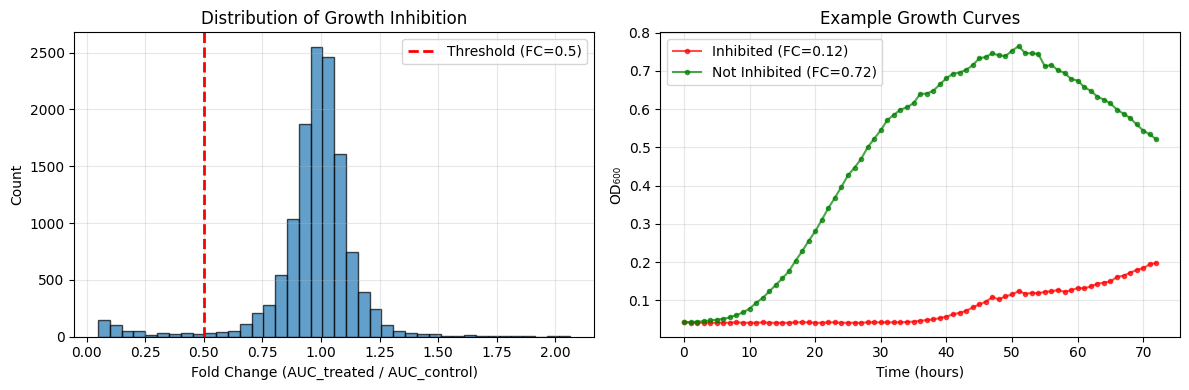

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of fold-changes
axes[0].hist(labels_df['fold_change'], bins=40, edgecolor='black', alpha=0.7)
axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold (FC=0.5)')
axes[0].set_xlabel('Fold Change (AUC_treated / AUC_control)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Growth Inhibition')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Example curves from each class
inhibited_ex = labels_df[labels_df['inhibited'] == 1].iloc[0]
not_inhibited_ex = labels_df[labels_df['inhibited'] == 0].iloc[0]

for sample, color, label_text in [(inhibited_ex, 'red', 'Inhibited'),
                                   (not_inhibited_ex, 'green', 'Not Inhibited')]:
    curve = data[(data[strain_col] == sample['strain']) & 
                 (data[chem_col] == sample['chemical']) & 
                 (data[rep_col] == sample['replicate'])]
    axes[1].plot(curve[time_col], curve[od_col], 'o-', color=color, 
                label=f"{label_text} (FC={sample['fold_change']:.2f})", alpha=0.7, markersize=3)

axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel('OD₆₀₀')
axes[1].set_title('Example Growth Curves')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


---

## The Class Imbalance Problem

Look carefully at the label distribution reported above. In this toxicology screening experiment, only 3.7% of samples (481 out of 12,929) are classified as "inhibited". This reflects the biological reality of the situation. These bacterial strains were isolated from contaminated environments - places with heavy metals, petroleum hydrocarbons, industrial solvents, and other toxic compounds. They survived and even thrived in those conditions, which means they've likely evolved resistance mechanisms. The chemicals tested here are agricultural pesticides, fungicides, and herbicides (compounds like thiabendazole, propiconazole, malathion, glyphosate, and over 160 others), and most aren't necessarily effective against these environmentally-adapted bacteria. So the low inhibition rate makes biological sense.

But this creates a serious machine learning challenge. With 96.3% of samples being "not inhibited", accuracy is the wrong metric for imbalanced data. Imagine a completely naive classifier that simply predicts "not inhibited" for every single sample without even looking at the growth curve data. If 96.3% of samples truly aren't inhibited, this classifier achieves 96.3% accuracy while being completely useless. It hasn't learned anything about the actual patterns that distinguish inhibited from uninhibited growth. It's just exploiting the class imbalance.

This is why we need more sophisticated evaluation metrics. **Precision** tells us: of all the samples we predicted as "inhibited", what fraction actually were inhibited? This matters because false positives (predicting inhibition when there was none) waste expensive follow-up validation experiments. **Recall** (also called sensitivity) tells us: of all the truly inhibited samples, what fraction did we successfully identify? This matters because false negatives (missing true inhibition) could mean overlooking a potentially useful antimicrobial compound. The **F1 score** is the harmonic mean of precision and recall, providing a single metric that balances both concerns. The **AUC** (Area Under the RP Curve) provides a threshold-independent measure of how well the model ranks samples: a perfect ranker (AUC = 1.0) places all truly inhibited samples ahead of all uninhibited ones.

During training, we need to handle the imbalance explicitly rather than hoping the model figures it out. 

---

## Extract Early-Time Data

Now we need to convert full growth curves into fixed-length feature vectors that our machine learning models can process. The raw data isn't uniformly sampled - measurements might be taken at slightly irregular intervals, some wells might have missing timepoints due to plate reader errors, and different replicates might have been measured at slightly different schedules. We need to standardize this into a common representation.

Our approach is to interpolate OD measurements at exact integer hours from 0 to MAX_HOURS. This gives us a consistent feature vector of length (MAX_HOURS + 1). For example, with MAX_HOURS = 24, we get OD values at hours 0, 1, 2, ..., 24, yielding a 25-dimensional vector for each sample. The interpolation is done using linear interpolation between measured timepoints, which is a reasonable approximation given that bacterial growth curves are generally smooth functions. We include several sanity checks: we skip samples with too few measurements to interpolate reliably (fewer than 3 timepoints), samples where the measurements don't cover the full time window (maximum time less than 80% of MAX_HOURS), and samples with obviously erroneous data (negative OD values, or unreasonably high values above 10.0 which would indicate measurement artifacts).


In [11]:
def extract_early_data(data_subset, max_hours=24, target_hours=None):
    """
    Interpolate OD at integer hours from 0 to max_hours.
    
    Returns array of length (max_hours + 1) or None if insufficient data.
    
    This function handles several data quality issues:
    - Duplicate timepoints are averaged
    - Sparse sampling is handled through linear interpolation
    - Outliers and measurement errors are filtered
    
    Performance note: We process samples individually because each has different
    numbers of measurements at different times. Vectorizing across samples isn't
    feasible without substantial complexity.
    """
    if len(data_subset) < 3:
        return None
    
    # Extract and check for NaN values early
    time_vals = data_subset[time_col].values
    od_vals = data_subset[od_col].values
    
    if np.any(np.isnan(time_vals)) or np.any(np.isnan(od_vals)):
        return None
    
    # Check time coverage before processing
    if time_vals.max() < max_hours * 0.8:
        return None
    
    if len(time_vals) != len(np.unique(time_vals)):
        temp_df = pd.DataFrame({'time': time_vals, 'od': od_vals})
        grouped = temp_df.groupby('time', as_index=False)['od'].mean()
        time_vals = grouped['time'].values
        od_vals = grouped['od'].values
    
    if target_hours is None:
        target_hours = np.arange(max_hours + 1)
    
    # Interpolate to integer hours
    try:
        interpolator = interp1d(time_vals, od_vals, kind='linear', 
                               bounds_error=False, fill_value='extrapolate')
        od_at_hours = interpolator(target_hours)
    except ValueError:
        # Can fail if time_vals has length < 2 after deduplication
        return None
    
    if (np.isnan(od_at_hours).any() or 
        (od_at_hours < 0).any() or 
        (od_at_hours > 3).any()):
        return None
    
    return od_at_hours

# Build dataset
print(f"Extracting {MAX_HOURS}-hour curves...")
print(f"Processing {len(labels_df)} samples...")

data_early = data[data[time_col] <= MAX_HOURS].copy().sort_values(time_col)

target_hours = np.arange(MAX_HOURS + 1)

X_raw, y_raw = [], []

for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Extracting curves"):
    subset = data_early[(data_early[strain_col] == row['strain']) & 
                        (data_early[chem_col] == row['chemical']) & 
                        (data_early[rep_col] == row['replicate'])]
    od_curve = extract_early_data(subset, MAX_HOURS, target_hours)
    if od_curve is not None:
        X_raw.append(od_curve)
        y_raw.append(row['inhibited'])

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)
n_features = MAX_HOURS + 1

print(f"Dataset: {X_raw.shape[0]} samples × {n_features} features")
print(f"Class balance: {y_raw.mean()*100:.1f}% inhibited")

Extracting 24-hour curves...
Processing 12929 samples...


Extracting curves: 100%|██████████████████████████████████████| 12929/12929 [05:26<00:00, 39.54it/s]

Dataset: 12877 samples × 25 features
Class balance: 3.7% inhibited


At this point, we have a matrix `X_raw` where each row is a growth curve and each column is an hour. This is the raw input we'll feed to our various machine learning approaches. Some methods (like the naive neural network) will use these values directly, while others (like PCA and feature engineering) will transform them first. The key thing to understand is that we've now converted a ragged collection of time series measurements into a clean, rectangular data matrix suitable for standard machine learning algorithms.

---

## Four Approaches to Classification

We'll compare four fundamentally different methods for extracting predictive information from early-time growth curves. Each represents a different philosophy about how to approach time-series classification, with different strengths and weaknesses.

### Setup: Train/Test Split

Before diving into the models, we need to split our data into training and test sets. The training set is what the models will learn from, while the test set remains completely hidden during training and is only used for final evaluation. This simulates deploying the model on new, unseen data.

We use stratified splitting, which ensures that both the training and test sets preserve the overall class balance. If 4% of samples in the full dataset are inhibited, then approximately 4% of samples in both the training and test sets will be inhibited.

We also standardize the features by subtracting the mean and dividing by the standard deviation (Z-score normalization). This is critical for neural networks and useful for other methods. Without standardization, features with larger absolute values dominate the learning process. Standardization puts all hours on the same scale, so the network treats patterns at all timepoints equally.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_raw, y_raw, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_raw
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=RANDOM_SEED, stratify=y_temp
)

# Standardize features (critical for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)} samples ({y_train.mean()*100:.1f}% inhibited)")
print(f"Validation: {len(X_val)} samples ({y_val.mean()*100:.1f}% inhibited)")
print(f"Test: {len(X_test)} samples ({y_test.mean()*100:.1f}% inhibited)")
print(f"\nValidation set will be used for threshold optimization")
print(f"Test set will remain untouched until final evaluation")

Training: 7725 samples (3.7% inhibited)
Validation: 2576 samples (3.7% inhibited)
Test: 2576 samples (3.7% inhibited)

Validation set will be used for threshold optimization
Test set will remain untouched until final evaluation


In [13]:
from sklearn import metrics

def rp_auc(y_true, y_scores, method="trapezoidal"):
    """
    Compute Precision–Recall AUC (RP AUC / AUPRC).

    Parameters
    ----------
    y_true : array-like, shape (n_samples,)
        True labels (0/1).
    y_scores : array-like, shape (n_samples,)
        Predicted probabilities or decision scores.
    method : {"trapezoidal", "average_precision"}
        - "trapezoidal": AUC using trapezoidal rule on PR curve
        - "average_precision": scikit-learn's average precision

    Returns
    -------
    float
        AUPRC value.
    """

    y_true = np.asarray(y_true)
    y_scores = np.asarray(y_scores)

    if method == "average_precision":
        return float(metrics.average_precision_score(y_true, y_scores))

    elif method == "trapezoidal":
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        return float(metrics.auc(recall, precision))

    else:
        raise ValueError("method must be 'trapezoidal' or 'average_precision'")



---

### Approach 1: Naive Neural Network

Here, we let a simple neural network figure everything out from the raw data. We just give it the OD values at each hour and let backpropagation discover the patterns.

This is the most "hands-off" approach. We're essentially saying: "I have time-series data, I have labels, now learn the mapping." The network architecture is deliberately simple: just two fully connected layers. The input layer has one neuron for each timepoint (25 neurons for a 24-hour window), connected to a hidden layer of 8 neurons with ReLU activation, which then connects to a single output neuron.

Mathematically, the forward pass computes:
$$\mathbf{h} = \text{ReLU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$$
$$z = \mathbf{w}_2^T \mathbf{h} + b_2$$

where $\mathbf{x}$ is the input (OD values), $\mathbf{h}$ is the hidden layer activation, and $z$ is the output logit. The ReLU (Rectified Linear Unit) activation function is simply $\text{ReLU}(x) = \max(0, x)$, which introduces nonlinearity while being computationally efficient.

We use `BCEWithLogitsLoss` (Binary Cross-Entropy with Logits Loss), which combines the sigmoid activation and binary cross-entropy loss in a single numerically stable operation. The loss function for a single sample is:

$$\mathcal{L} = -w \cdot y \log(\sigma(z)) - (1-y) \log(1-\sigma(z))$$

where $\sigma(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function and $w$ is the positive class weight. The weight $w$ is what handles class imbalance - mistakes on inhibited samples (y=1) are penalized $w$ times more heavily than mistakes on uninhibited samples.

For our weight calculation, we use square root damping:

$$\text{pos\_weight} = \sqrt{\frac{n_{\text{negative}}}{n_{\text{positive}}}}$$

This is less aggressive than the full ratio $\frac{n_{\text{negative}}}{n_{\text{positive}}}$, which prevents the model from becoming too eager to predict "inhibited" and generating excessive false positives.


Class weights: 7436 negative, 289 positive → pos_weight=5.07
Model architecture: 217 total parameters


Training Naive NN: 100%|████████████████████████████████████| 10000/10000 [00:04<00:00, 2044.01it/s]



Training complete. Final loss: 0.0644


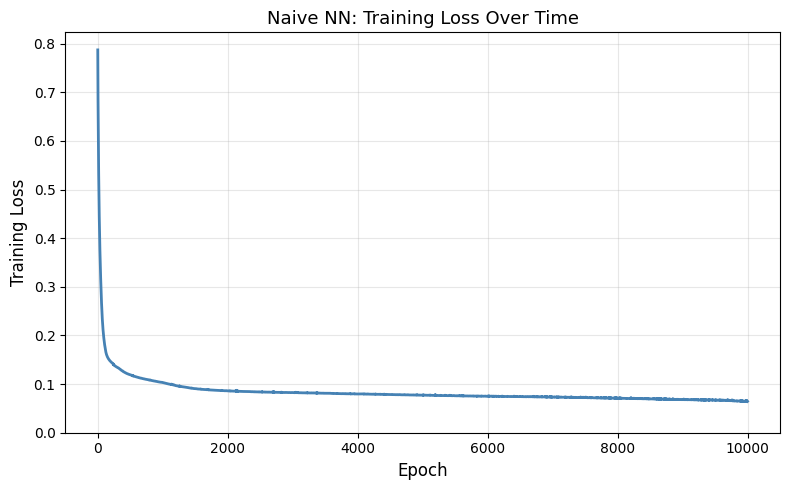

In [14]:
class NaiveNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.fc2 = nn.Linear(8, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # No sigmoid - BCEWithLogitsLoss applies it internally

# Initialize model
model_naive = NaiveNN(n_features)

# Compute damped class weights
n_positive = y_train.sum()
n_negative = len(y_train) - n_positive
pos_weight = np.sqrt(n_negative / n_positive)

print(f"Class weights: {n_negative} negative, {n_positive} positive → pos_weight={pos_weight:.2f}")
print(f"Model architecture: {sum(p.numel() for p in model_naive.parameters())} total parameters")

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
optimizer = optim.Adam(model_naive.parameters(), lr=0.01)

# Train and track loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

model = model_naive.to(device)

train_losses = []
for epoch in tqdm(range(10000), desc="Training Naive NN"):
    model.train()

    optimizer.zero_grad(set_to_none=True)

    logits = model(X_tensor)
    loss = criterion(logits, y_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())


print(f"\nTraining complete. Final loss: {loss.item():.4f}")

# Plot training loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, linewidth=2, color='steelblue')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Naive NN: Training Loss Over Time', fontsize=13)
ax.set_ylim(bottom=0)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The training loss plot shows a smooth, monotonically decreasing curve. The loss drops rapidly in the first few hundred epochs as the network discovers the basic pattern (inhibited samples have consistently lower OD values throughout the time course), then continues to decrease more gradually as it fine-tunes the decision boundary.


In [15]:
# Evaluate on validation set
model_naive.eval()
with torch.no_grad():
    logits_val = model_naive(torch.FloatTensor(X_val_scaled)).numpy().flatten()
    y_pred_naive_prob_val = expit(logits_val)  # Numerically stable sigmoid
    y_pred_naive_val = (y_pred_naive_prob_val > 0.5).astype(int)

acc_naive = accuracy_score(y_val, y_pred_naive_val)
prec_naive = precision_score(y_val, y_pred_naive_val, zero_division=0)
rec_naive = recall_score(y_val, y_pred_naive_val, zero_division=0)
f1_naive = f1_score(y_val, y_pred_naive_val, zero_division=0)
auc_naive = rp_auc(y_val, y_pred_naive_prob_val)

print(f"\nNaive NN Results on Validation Set (threshold=0.5):")
print(f"  Accuracy:  {acc_naive:.3f}")
print(f"  Precision: {prec_naive:.3f}")
print(f"  Recall:    {rec_naive:.3f}")
print(f"  F1 Score:  {f1_naive:.3f}")
print(f"  AUC:       {auc_naive:.3f}")


Naive NN Results on Validation Set (threshold=0.5):
  Accuracy:  0.987
  Precision: 0.804
  Recall:    0.854
  F1 Score:  0.828
  AUC:       0.796



The training loss plot shows a characteristic curve: rapid initial decrease as the network discovers basic patterns (exponential vs flat growth), followed by slower convergence as it fine-tunes the decision boundary. If you see the loss oscillating wildly or increasing, that suggests the learning rate is too high or the network architecture is inappropriate.

The network is learning to combine the OD values at different hours in a way that predicts inhibition. The weights in the first layer learn to recognize patterns like "low OD throughout" or "flat trajectory after hour 12". The hidden layer combines these patterns. But here's the critical limitation: the network treats each hour as an independent feature. It doesn't inherently understand that hour 13 follows hour 12, that growth curves have temporal structure, or that the relationship between consecutive timepoints matters. It could learn some of this implicitly if given enough data, but with our limited training set, this is a handicap.

The network is also not scale-invariant. Remember that different bacterial strains naturally grow to different densities. A strain that reaches OD = 2.0 at stationary phase and another that reaches OD = 0.8 are both "healthy", but the network sees these as numerically very different inputs. While standardization helps by putting all samples on the same relative scale, the network still has to learn that "high OD for this strain" maps to "not inhibited" rather than having that knowledge built in.

---

### Approach 2: PCA - Data-Driven Dimensionality Reduction

The 25 OD measurements (one per hour) contain substantial redundancy. Neighboring hours are highly correlated - if OD at hour 12 is high, OD at hour 13 is probably also high. Growth curves lie on a lower-dimensional manifold embedded in this 25-dimensional space. Let's find that manifold using Principal Component Analysis and work in the reduced space.

Principal Component Analysis (PCA) is a classic unsupervised dimensionality reduction technique. Given a data matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$ (n samples, d features), PCA finds orthogonal directions in feature space that capture the most variance. Mathematically, this amounts to computing the eigenvectors of the covariance matrix:

$$\mathbf{C} = \frac{1}{n}\mathbf{X}^T\mathbf{X}$$
$$\mathbf{C}\mathbf{v}_k = \lambda_k \mathbf{v}_k$$

The first principal component $\mathbf{v}_1$ points in the direction of maximum variance in the data. The second PC $\mathbf{v}_2$ is orthogonal to $\mathbf{v}_1$ and points in the direction of maximum remaining variance, and so on. The eigenvalues $\lambda_k$ tell us how much variance each PC captures. In our case with bacterial growth curves, the first few PCs capture most of the variance. Specifically, the first 3 PCs capture 96.7% of the total variance. This allows us to project from 25 dimensions down to just 3 dimensions while retaining nearly all the information.

However, there's a subtle issue we need to address. PCA is an unsupervised method - it finds variance directions without considering class labels. With our imbalanced dataset where 96% of samples are uninhibited, PCA will naturally be dominated by variance patterns within the majority class. The uninhibited samples might vary in terms of how fast they grow, what final density they reach, whether they have a long lag phase, etc. PCA will find axes that capture these variations. Meanwhile, the patterns that distinguish inhibited samples from uninhibited ones might be relegated to later principal components (PC4, PC5, etc.) that we discard.

To address this, we can use SMOTE (Synthetic Minority Over-sampling Technique) before applying PCA. SMOTE generates synthetic inhibited samples by finding k-nearest neighbors among existing inhibited samples and creating new samples by linear interpolation between them. This balances the dataset to 50-50, ensuring that PCA gives equal weight to variance patterns in both classes.


Balancing training data with SMOTE before PCA...
  Before: 7725 samples (289 inhibited)
  After:  14872 samples (7436 inhibited)

Fitting PCA...

Variance explained by 3 PCs: 96.9%
  PC1: 81.2%
  PC2: 11.8%
  PC3: 3.9%


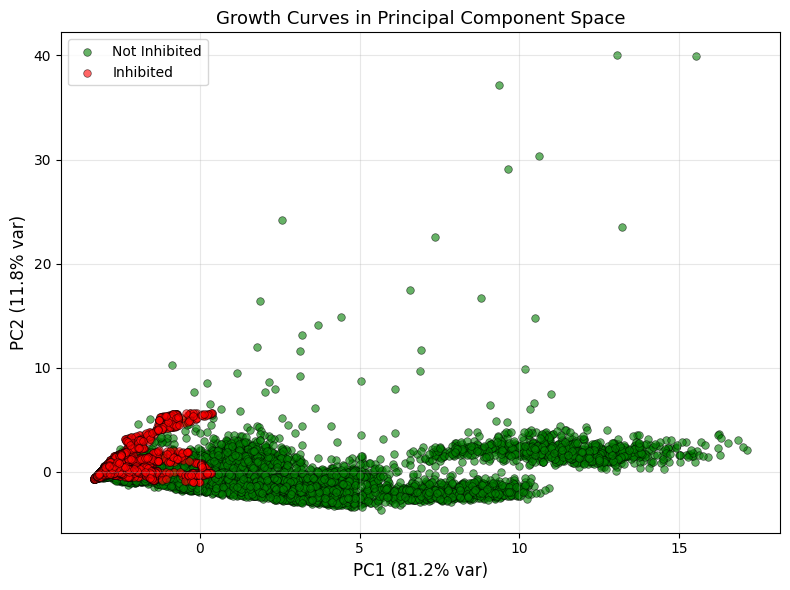


Training Logistic Regression on PCA features...

PCA + Logistic Regression Results on Validation Set (threshold=0.5):
  Accuracy:  0.898
  Precision: 0.257
  Recall:    0.917
  F1 Score:  0.401
  AUC:       0.589


In [16]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

USE_SMOTE = True  # Set to False to compare

if USE_SMOTE:
    print("Balancing training data with SMOTE before PCA...")
    smote = SMOTE(random_state=RANDOM_SEED)
    X_train_pca, y_train_pca = smote.fit_resample(X_train_scaled, y_train)
    print(f"  Before: {len(y_train)} samples ({y_train.sum()} inhibited)")
    print(f"  After:  {len(y_train_pca)} samples ({y_train_pca.sum()} inhibited)")
else:
    X_train_pca, y_train_pca = X_train_scaled, y_train

# Fit PCA
print("\nFitting PCA...")
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_pca)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

var_explained = pca.explained_variance_ratio_
print(f"\nVariance explained by 3 PCs: {var_explained.sum()*100:.1f}%")
print(f"  PC1: {var_explained[0]*100:.1f}%")
print(f"  PC2: {var_explained[1]*100:.1f}%")
print(f"  PC3: {var_explained[2]*100:.1f}%")

# Visualize PC space
fig, ax = plt.subplots(figsize=(8, 6))
scatter0 = ax.scatter(X_train_pca[y_train_pca==0, 0], X_train_pca[y_train_pca==0, 1],
                     c='green', alpha=0.6, s=30, label='Not Inhibited', edgecolors='k', linewidth=0.5)
scatter1 = ax.scatter(X_train_pca[y_train_pca==1, 0], X_train_pca[y_train_pca==1, 1],
                     c='red', alpha=0.6, s=30, label='Inhibited', edgecolors='k', linewidth=0.5)
ax.set_xlabel(f'PC1 ({var_explained[0]*100:.1f}% var)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]*100:.1f}% var)', fontsize=12)
ax.set_title('Growth Curves in Principal Component Space', fontsize=13)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Train classifier on PCs
print("\nTraining Logistic Regression on PCA features...")
model_pca = LogisticRegression(
    class_weight=None if USE_SMOTE else 'balanced',
    max_iter=1000,
    random_state=RANDOM_SEED
)
model_pca.fit(X_train_pca, y_train_pca)

# Evaluate on validation set
y_pred_pca_prob_val = model_pca.predict_proba(X_val_pca)[:, 1]
y_pred_pca_val = (y_pred_pca_prob_val > 0.5).astype(int)

acc_pca = accuracy_score(y_val, y_pred_pca_val)
prec_pca = precision_score(y_val, y_pred_pca_val, zero_division=0)
rec_pca = recall_score(y_val, y_pred_pca_val, zero_division=0)
f1_pca = f1_score(y_val, y_pred_pca_val, zero_division=0)
auc_pca = rp_auc(y_val, y_pred_pca_prob_val)

print(f"\nPCA + Logistic Regression Results on Validation Set (threshold=0.5):")
print(f"  Accuracy:  {acc_pca:.3f}")
print(f"  Precision: {prec_pca:.3f}")
print(f"  Recall:    {rec_pca:.3f}")
print(f"  F1 Score:  {f1_pca:.3f}")
print(f"  AUC:       {auc_pca:.3f}")

While PCA reduces dimensionality and reveals structure, the principal components themselves lack biological interpretation. If I tell you a sample has PC1 = 0.3 and PC2 = -0.8, what does that actually mean in terms of the bacterial growth process? It's not immediately clear. The PCs are linear combinations of all the original hours, weighted by somewhat arbitrary coefficients that happen to maximize variance. This makes PCA useful as a preprocessing step or for visualization, but less satisfying as a final answer if you want to understand what's actually happening biologically.

---

### Approach 3: Biological Feature Engineering

Instead of letting statistics or neural networks discover patterns, let's explicitly extract features that make biological sense. This is the "domain knowledge" approach. Rather than working with 25 OD measurements or abstract principal components, we'll compute 5 biologically meaningful features that capture the essential dynamics of growth. These features are chosen based on decades of microbiology research about how bacteria respond to environmental stressors.

**Feature 1: Area Under the Curve (AUC)**. This is the integral of OD from 0 to MAX_HOURS:

$$\text{AUC}_{\text{early}} = \int_0^{\text{MAX\_HOURS}} \text{OD}(t) \, dt$$

A bacterium that's been inhibited simply doesn't produce as much biomass, regardless of the specific mechanism. This parallels our labeling metric and should be highly predictive. We compute it using trapezoidal integration, which approximates the integral as a sum of trapezoids between consecutive timepoints.

**Feature 2: Maximum Growth Rate (μ)**. During exponential phase, bacterial population follows first-order kinetics:

$$N(t) = N_0 e^{\mu t}$$

where μ is the specific growth rate (in units of hour⁻¹). Since OD is proportional to cell number, we have:

$$\text{OD}(t) = \text{OD}_0 e^{\mu t}$$
$$\ln(\text{OD}(t)) = \ln(\text{OD}_0) + \mu t$$

So μ is the slope of ln(OD) versus time during exponential phase. We estimate this from the last half of our measurement window using linear regression on log-transformed OD values. A healthy culture should have μ in the range 0.1-2.0 hour⁻¹ depending on the species and conditions. An inhibited culture typically shows μ ≈ 0, indicating no net exponential growth.

**Feature 3: Recent Slope**. The current trajectory tells us where the culture is heading. We fit a linear trend to the last 5 timepoints (the most recent ~5 hours):

$$\text{slope} = \frac{d(\text{OD})}{dt}\bigg|_{\text{recent}}$$

A positive slope indicates continued growth, zero slope suggests the culture has plateaued, and negative slope might indicate cell death or lysis. This complements the growth rate feature by capturing very recent dynamics that might not follow exponential kinetics.

**Feature 4: Current OD**. Simply the OD at MAX_HOURS - the most recent measurement. This is a straightforward endpoint assessment: how much biomass has accumulated so far? Combined with the other features, it helps distinguish between "not growing yet" and "finished growing".

**Feature 5: Has Growth Started?**. A binary indicator of whether exponential phase has initiated. We define this as:

$$\text{started} = \begin{cases} 1 & \text{if OD}_{\text{current}} > \text{OD}_{\text{baseline}} + 0.1 \\ 0 & \text{otherwise} \end{cases}$$

where baseline is the average of the first 3 measurements. Some inhibited cultures never start growing at all - they remain at inoculum density throughout. This binary feature captures that qualitative difference.


Extracting biological features from all growth curves...


100%|███████████████████████████████████████████████████████| 12877/12877 [00:01<00:00, 6780.33it/s]



Extracted 12877 feature vectors

Feature statistics:
                AUC   Growth Rate         Slope    Current OD       Started
count  12877.000000  12877.000000  12877.000000  12877.000000  12877.000000
mean       6.690420      0.074228      0.021413      0.604165      0.901918
std        4.163092      0.041262      0.018521      0.344371      0.297437
min        0.976009     -0.082694     -0.107758      0.039007      0.000000
25%        3.468897      0.045795      0.009533      0.318757      1.000000
50%        5.692501      0.067268      0.020498      0.581952      1.000000
75%        9.013958      0.100363      0.031113      0.897617      1.000000
max       19.692714      0.238422      0.134909      1.633973      1.000000


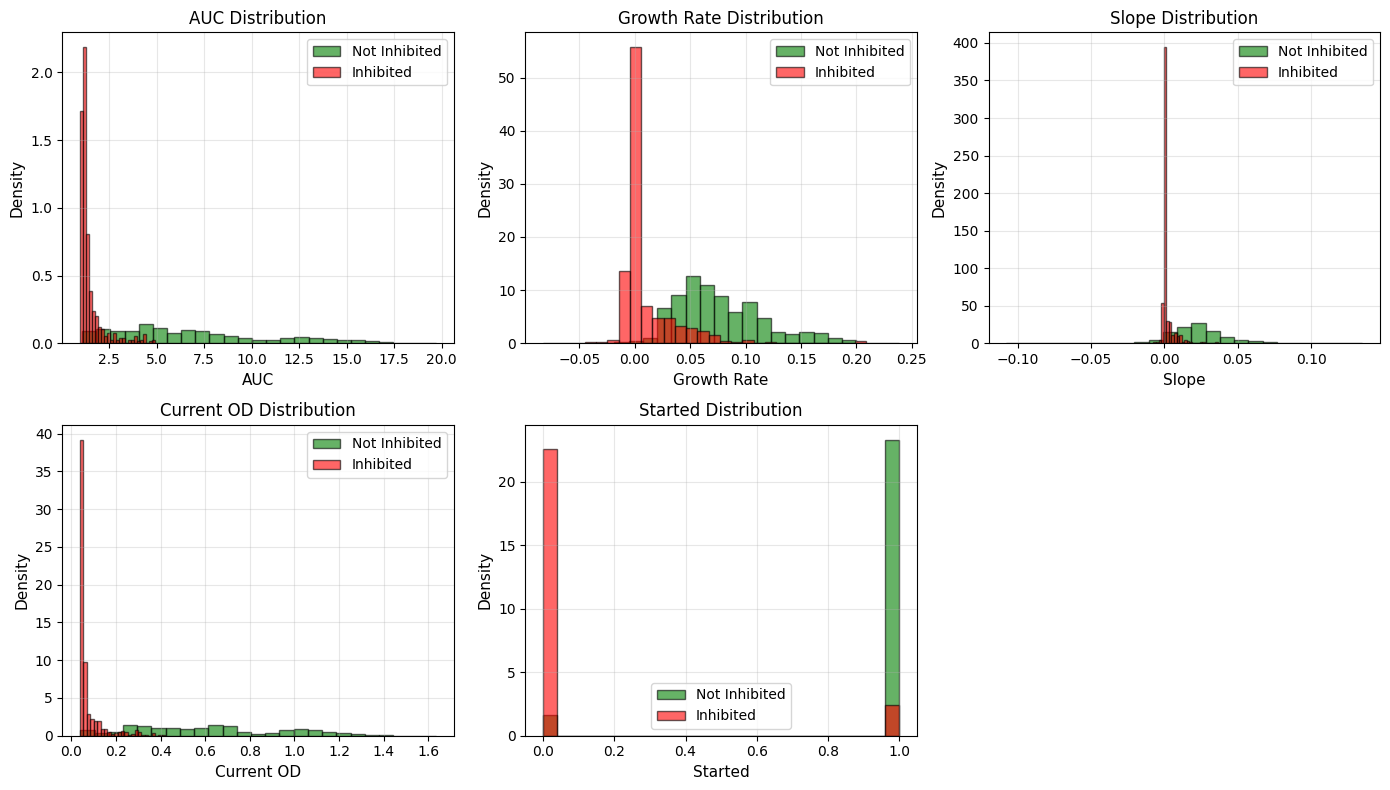

In [17]:
def extract_features(od_curve):
    """
    Extract 5 biological features from growth curve.
    
    These features capture different aspects of growth physiology:
    1. AUC: Total biomass production
    2. Growth rate: Exponential phase kinetics
    3. Slope: Recent trajectory
    4. Current OD: Endpoint biomass
    5. Started: Binary indicator of growth initiation
    
    Returns numpy array of length 5, or None if data quality is insufficient.
    """
    if len(od_curve) < 5 or np.any(np.isnan(od_curve)):
        return None
    
    # Smooth the curve to reduce noise in derivatives
    od_smooth = savgol_filter(od_curve, window_length=5, polyorder=2) if len(od_curve) >= 7 else od_curve.copy()
    
    # Feature 1: AUC from 0 to MAX_HOURS
    time_points = np.arange(len(od_curve))
    auc = np.trapezoid(od_curve, time_points)
    
    # Feature 2: Maximum growth rate (use last half of curve)
    n_for_growth = max(6, len(od_smooth) // 2)
    od_for_log = od_smooth[-n_for_growth:]
    
    if np.any(od_for_log <= 0):
        growth_rate = 0.0
    else:
        try:
            # Add small constant to avoid log(0), then fit linear trend
            log_od = np.log(od_for_log + 0.001)
            time_indices = np.arange(len(log_od))
            growth_rate = np.polyfit(time_indices, log_od, deg=1)[0]  # Slope
            
            # Sanity check: typical μ for bacteria is 0.1-2.0 hour⁻¹
            # Faster growth suggests measurement artifacts
            if np.isnan(growth_rate) or abs(growth_rate) > 3:
                growth_rate = 0.0
        except:
            growth_rate = 0.0
    
    # Feature 3: Recent slope (last 5 timepoints)
    if len(od_smooth) >= 5:
        try:
            slope = np.polyfit(np.arange(5), od_smooth[-5:], deg=1)[0]
            if np.isnan(slope):
                slope = 0.0
        except:
            slope = 0.0
    else:
        slope = 0.0
    
    # Feature 4: Current OD at final timepoint
    current_od = od_curve[-1]
    
    # Feature 5: Has growth started?
    baseline = np.mean(od_curve[:3])
    has_started = 1 if current_od > baseline + 0.1 else 0
    
    return np.array([auc, growth_rate, slope, current_od, has_started])

# Extract features for all samples
print("Extracting biological features from all growth curves...")
X_features = []
y_features = []

for i in tqdm(range(len(X_raw))):
    features = extract_features(X_raw[i])
    if features is not None:
        X_features.append(features)
        y_features.append(y_raw[i])

X_features = np.array(X_features)
y_features = np.array(y_features)

feature_names = ['AUC', 'Growth Rate', 'Slope', 'Current OD', 'Started']
print(f"\nExtracted {len(X_features)} feature vectors")

# Summary statistics
print("\nFeature statistics:")
feat_df = pd.DataFrame(X_features, columns=feature_names)
print(feat_df.describe())

# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, name in enumerate(feature_names):
    not_inh = X_features[y_features==0, i]
    inh = X_features[y_features==1, i]
    
    axes[i].hist(not_inh, bins=25, alpha=0.6, label='Not Inhibited',
                color='green', edgecolor='black', density=True)
    axes[i].hist(inh, bins=25, alpha=0.6, label='Inhibited',
                color='red', edgecolor='black', density=True)
    
    axes[i].set_xlabel(name, fontsize=11)
    axes[i].set_ylabel('Density', fontsize=11)
    axes[i].set_title(f'{name} Distribution', fontsize=12)
    axes[i].legend(fontsize=10)
    axes[i].grid(alpha=0.3)

axes[5].axis('off')
plt.tight_layout()
plt.show()


Now we train a logistic regression classifier on these five features:


Training Logistic Regression on biological features...

Biological Features + Logistic Regression (threshold=0.5):
  Accuracy:  0.916
  Precision: 0.296
  Recall:    0.906
  F1 Score:  0.446
  AUC:       0.810


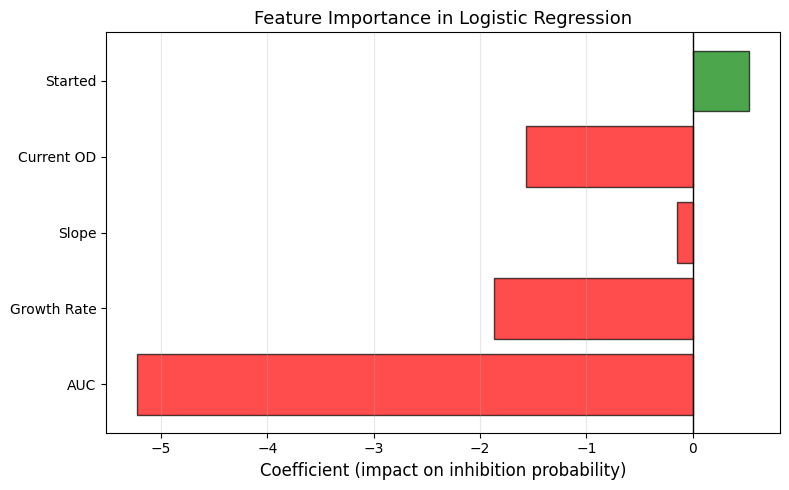


Feature coefficients (negative = decreases inhibition probability):
  AUC            : -5.225
  Growth Rate    : -1.867
  Slope          : -0.148
  Current OD     : -1.570
  Started        : +0.532


In [18]:
# Split into train/val/test: 60/20/20
X_temp_f, X_test_f, y_temp_f, y_test_f = train_test_split(
    X_features, y_features, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_features
)

X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(
    X_temp_f, y_temp_f, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=RANDOM_SEED, stratify=y_temp_f
)

scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_val_f_scaled = scaler_f.transform(X_val_f)
X_test_f_scaled = scaler_f.transform(X_test_f)

print("Training Logistic Regression on biological features...")
model_features = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
model_features.fit(X_train_f_scaled, y_train_f)

# Evaluate on validation set
y_pred_f_prob_val = model_features.predict_proba(X_val_f_scaled)[:, 1]
y_pred_f_val = (y_pred_f_prob_val > 0.5).astype(int)

acc_features = accuracy_score(y_val_f, y_pred_f_val)
prec_features = precision_score(y_val_f, y_pred_f_val, zero_division=0)
rec_features = recall_score(y_val_f, y_pred_f_val, zero_division=0)
f1_features = f1_score(y_val_f, y_pred_f_val, zero_division=0)
auc_features = rp_auc(y_val_f, y_pred_f_prob_val)

print(f"\nBiological Features + Logistic Regression (threshold=0.5):")
print(f"  Accuracy:  {acc_features:.3f}")
print(f"  Precision: {prec_features:.3f}")
print(f"  Recall:    {rec_features:.3f}")
print(f"  F1 Score:  {f1_features:.3f}")
print(f"  AUC:       {auc_features:.3f}")

# Feature importance
coefficients = model_features.coef_[0]

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['green' if c > 0 else 'red' for c in coefficients]
ax.barh(feature_names, coefficients, color=colors, alpha=0.7, edgecolor='black')
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('Coefficient (impact on inhibition probability)', fontsize=12)
ax.set_title('Feature Importance in Logistic Regression', fontsize=13)
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nFeature coefficients (negative = decreases inhibition probability):")
for name, coef in zip(feature_names, coefficients):
    print(f"  {name:15s}: {coef:+.3f}")



---

### Approach 4: Deep Learning with 1D CNN

We've now seen three different approaches. The naive neural network treated each timepoint independently, ignoring temporal structure. PCA found data-driven patterns but without considering which patterns actually predict inhibition. Biological feature engineering achieved the best performance by explicitly extracting five physiologically meaningful features. But this raises an important question: Are we still imposing too much structure? What if we're missing patterns that we haven't thought to look for?

This is where deep learning promises something different. The hand-crafted features are based on our current understanding of bacterial growth physiology. But bacterial responses to toxic stress are complex. Maybe there are subtle patterns in the lag phase dynamics, or specific combinations of early and late timepoints, or transient oscillations that we haven't thought to measure. Can a Convolutional Neural Network automatically discover better features directly from the raw time series, without us having to specify what to look for?

CNNs have revolutionized image recognition by automatically learning hierarchical feature representations. The same principle applies to time series: a 1D CNN can learn to recognize temporal patterns (slopes, inflection points, exponential phases, plateaus, and potentially patterns we haven't imagined) without being explicitly programmed to look for them. Unlike the naive neural network which treats hours 5 and 6 as independent features, the CNN understands that consecutive timepoints are related through its convolutional filters.

A 1D convolutional layer operates by sliding learned filter kernels across the time series. Each filter is a small window (kernel_size = 3 timepoints in our case) that computes:

$$h_i = \text{ReLU}\left(\sum_{j=0}^{k-1} w_j \cdot x_{i+j} + b\right)$$

where $k$ is the kernel size, $w_j$ are the learned filter weights, and $x_{i+j}$ are the input values. The filter slides from position 0 to position (n-k), computing one output value at each position. Critically, the same weights $w_j$ are applied at every position.

With multiple filters, we get multiple feature maps, each potentially learning to detect a different temporal pattern. One filter might learn to recognize exponential growth, another might detect plateau behavior, another might identify the transition from lag phase to exponential phase. The beauty is that we don't specify what patterns to look for - the network learns them from the data during training.

CNN Architecture: 1489 parameters

Training 1D CNN...


Training CNN: 100%|███████████████████████████████████████████████| 500/500 [11:04<00:00,  1.33s/it]


Training complete. Final loss: 0.1446


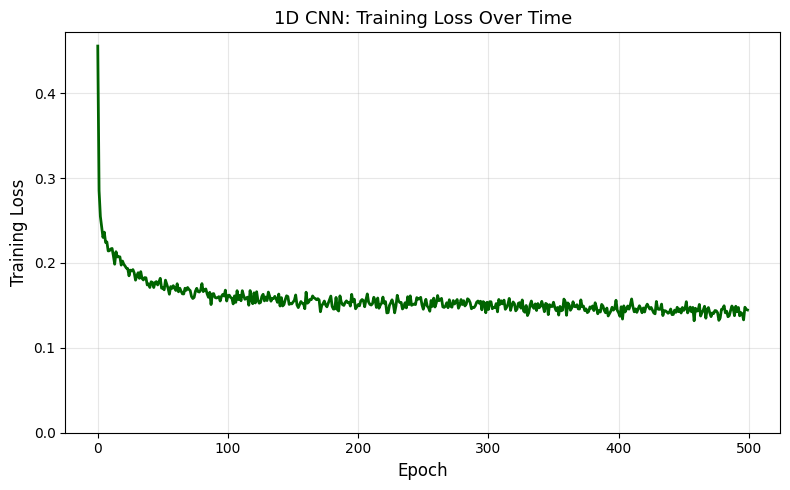

In [19]:
class CNN1D(nn.Module):
    def __init__(self, input_length):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        # After conv (length-2) and pool (/2): pooled_size = (length-2)/2
        self.pooled_size = (input_length - 2) // 2
        self.fc1 = nn.Linear(16 * self.pooled_size, 8)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(8, 1)
    
    def forward(self, x):
        # Add channel dimension: (batch, length) → (batch, 1, length)
        x = x.unsqueeze(1)
        
        # Convolutional + pooling
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        
        # Flatten and dense layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Initialize
model_cnn = CNN1D(n_features)
pos_weight_cnn = np.sqrt((y_train == 0).sum() / (y_train == 1).sum())
criterion_cnn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_cnn]))
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

print(f"CNN Architecture: {sum(p.numel() for p in model_cnn.parameters())} parameters")

# Train with mini-batches and track loss
batch_size = 32
n_epochs = 500

print("\nTraining 1D CNN...")
train_losses_cnn = []

for epoch in tqdm(range(n_epochs), desc="Training CNN"):
    model_cnn.train()
    epoch_losses = []
    
    for i in range(0, len(X_train_scaled), batch_size):
        batch_X = torch.FloatTensor(X_train_scaled[i:i+batch_size])
        batch_y = torch.FloatTensor(y_train[i:i+batch_size]).view(-1, 1)
        
        logits = model_cnn(batch_X)
        loss = criterion_cnn(logits, batch_y)
        
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    train_losses_cnn.append(avg_loss)

print(f"\nTraining complete. Final loss: {train_losses_cnn[-1]:.4f}")

# Plot training loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses_cnn, linewidth=2, color='darkgreen')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('1D CNN: Training Loss Over Time', fontsize=13)
ax.set_ylim(bottom=0)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The training loss curve for the CNN shows more variability compared to the Naive NN. You'll notice some fluctuations and occasional small spikes, rather than a perfectly smooth descent. This is expected behavior for mini-batch training (batch_size=32). Each epoch averages the loss across multiple mini-batches, and different batches can have quite different loss values - especially with severe class imbalance where some batches might contain zero inhibited samples while others contain several. The dropout layer (p=0.3) also introduces stochasticity during training, causing some epoch-to-epoch variation. Despite the shakiness, the overall trend is clearly downward, indicating the network is learning.


In [20]:
# Evaluate on validation set
model_cnn.eval()
with torch.no_grad():
    logits_val = model_cnn(torch.FloatTensor(X_val_scaled)).numpy().flatten()
    y_pred_cnn_prob_val = expit(logits_val)
    y_pred_cnn_val = (y_pred_cnn_prob_val > 0.5).astype(int)

acc_cnn = accuracy_score(y_val, y_pred_cnn_val)
prec_cnn = precision_score(y_val, y_pred_cnn_val, zero_division=0)
rec_cnn = recall_score(y_val, y_pred_cnn_val, zero_division=0)
f1_cnn = f1_score(y_val, y_pred_cnn_val, zero_division=0)
auc_cnn = rp_auc(y_val, y_pred_cnn_prob_val)

print(f"\n1D CNN Results on Validation Set (threshold=0.5):")
print(f"  Accuracy:  {acc_cnn:.3f}")
print(f"  Precision: {prec_cnn:.3f}")
print(f"  Recall:    {rec_cnn:.3f}")
print(f"  F1 Score:  {f1_cnn:.3f}")
print(f"  AUC:       {auc_cnn:.3f}")


1D CNN Results on Validation Set (threshold=0.5):
  Accuracy:  0.974
  Precision: 0.604
  Recall:    0.844
  F1 Score:  0.704
  AUC:       0.853



---

## Threshold Optimization

At this point, we have four trained models, each evaluated at the default threshold of 0.5. But look closely at the results - many models show high AUC (often >0.85) but varying F1 scores. This reveals something important: with imbalanced data and different imbalance-handling strategies, the default 0.5 threshold is rarely optimal.

The solution is to optimize the threshold for each model based on validation data. For each possible threshold, we compute precision and recall, then calculate F1 score. The threshold that maximizes F1 is our optimal operating point.


In [21]:
from sklearn.metrics import precision_recall_curve

def optimize_threshold(y_true, y_pred_prob, model_name):
    """
    Find threshold that maximizes F1 score.
    
    For imbalanced data with class weighting, the default 0.5 threshold
    is often suboptimal. This function searches across all possible thresholds
    to find the one that best balances precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    
    # Compute F1 at each threshold (precision/recall arrays are 1 element longer than thresholds)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)
    
    # Compare to default threshold
    f1_default = f1_score(y_true, (y_pred_prob > 0.5).astype(int), zero_division=0)
    
    improvement = ((best_f1 - f1_default) / f1_default * 100) if f1_default > 0 else 0
    
    print(f"{model_name:12s}: Default F1={f1_default:.3f} → Optimal F1={best_f1:.3f} " + 
          f"(threshold={best_threshold:.3f}, +{improvement:.1f}% improvement)")
    
    return best_threshold, best_f1

print("Threshold Optimization on Validation Set:")
print("="*80)
print("Finding optimal decision thresholds to maximize F1 score...\n")

threshold_nn, f1_nn_opt = optimize_threshold(y_val, y_pred_naive_prob_val, 'Naive NN')
threshold_pca, f1_pca_opt = optimize_threshold(y_val, y_pred_pca_prob_val, 'PCA')
threshold_feat, f1_feat_opt = optimize_threshold(y_val_f, y_pred_f_prob_val, 'Features')
threshold_cnn, f1_cnn_opt = optimize_threshold(y_val, y_pred_cnn_prob_val, 'CNN')


Threshold Optimization on Validation Set:
Finding optimal decision thresholds to maximize F1 score...

Naive NN    : Default F1=0.828 → Optimal F1=0.856 (threshold=0.775, +3.3% improvement)
PCA         : Default F1=0.401 → Optimal F1=0.728 (threshold=0.935, +81.7% improvement)
Features    : Default F1=0.446 → Optimal F1=0.835 (threshold=0.971, +87.2% improvement)
CNN         : Default F1=0.704 → Optimal F1=0.846 (threshold=0.659, +20.1% improvement)



---



## Summary Table

Finally, let's compile all results into a comprehensive summary table:


In [22]:
# Create summary
results_summary = pd.DataFrame({
    'Model': ['Naive NN', 'PCA', 'Features', 'CNN'],
    'AUC': [auc_naive, auc_pca, auc_features, auc_cnn],
    'F1 (default)': [f1_naive, f1_pca, f1_features, f1_cnn],
    'F1 (optimized)': [f1_nn_opt, f1_pca_opt, f1_feat_opt, f1_cnn_opt],
    'Optimal threshold': [threshold_nn, threshold_pca, threshold_feat, threshold_cnn],
    'Interpretable': ['No', 'Somewhat', 'Yes', 'No'],
    'N parameters': ['~100', '3', '5', '~200']
})

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(results_summary.to_string(index=False))
print("="*80)


FINAL RESULTS SUMMARY
   Model      AUC  F1 (default)  F1 (optimized)  Optimal threshold Interpretable N parameters
Naive NN 0.795679      0.828283        0.855615           0.774928            No         ~100
     PCA 0.589103      0.400911        0.728324           0.934899      Somewhat            3
Features 0.810147      0.446154        0.835294           0.970673           Yes            5
     CNN 0.852743      0.704348        0.845714           0.659424            No         ~200


In [23]:
print("="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)
print("Using optimized thresholds from validation set\n")

# Generate predictions on test set for all models
# Naive NN
model_naive.eval()
with torch.no_grad():
    y_pred_naive_prob_test = expit(model_naive(torch.FloatTensor(X_test_scaled)).numpy().flatten())
y_pred_naive_test = (y_pred_naive_prob_test > threshold_nn).astype(int)

# PCA
y_pred_pca_prob_test = model_pca.predict_proba(X_test_pca)[:, 1]
y_pred_pca_test = (y_pred_pca_prob_test > threshold_pca).astype(int)

# Features  
y_pred_f_prob_test = model_features.predict_proba(X_test_f_scaled)[:, 1]
y_pred_f_test = (y_pred_f_prob_test > threshold_feat).astype(int)

# CNN
model_cnn.eval()
with torch.no_grad():
    y_pred_cnn_prob_test = expit(model_cnn(torch.FloatTensor(X_test_scaled)).numpy().flatten())
y_pred_cnn_test = (y_pred_cnn_prob_test > threshold_cnn).astype(int)

# Compute final metrics
results = []
for name, y_true, y_prob, y_pred, threshold in [
    ('Naive NN', y_test, y_pred_naive_prob_test, y_pred_naive_test, threshold_nn),
    ('PCA', y_test, y_pred_pca_prob_test, y_pred_pca_test, threshold_pca),
    ('Features', y_test_f, y_pred_f_prob_test, y_pred_f_test, threshold_feat),
    ('CNN', y_test, y_pred_cnn_prob_test, y_pred_cnn_test, threshold_cnn)
]:
    auc = rp_auc(y_true, y_prob)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    
    results.append({
        'Model': name,
        'AUC': auc,
        'F1': f1,
        'Precision': prec,
        'Recall': rec,
        'Threshold': threshold
    })
    
    print(f"{name:12s}: AUC={auc:.3f}, F1={f1:.3f}, Precision={prec:.3f}, Recall={rec:.3f} (τ={threshold:.3f})")


FINAL TEST SET EVALUATION
Using optimized thresholds from validation set

Naive NN    : AUC=0.717, F1=0.802, Precision=0.802, Recall=0.802 (τ=0.775)
PCA         : AUC=0.635, F1=0.646, Precision=0.800, Recall=0.542 (τ=0.935)
Features    : AUC=0.829, F1=0.790, Precision=0.930, Recall=0.688 (τ=0.971)
CNN         : AUC=0.824, F1=0.807, Precision=0.887, Recall=0.740 (τ=0.659)


---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).